In [1]:
import pandas as pd

In [2]:
stage = "/maven_iuvs/stage/products/level1b/IUVS_L1B_index_summary.txt"
production = '/maven_iuvs/production/products/level1b/IUVS_L1B_index_summary.txt'
l1b_metadata = pd.read_table(stage, skiprows=26, skipinitialspace=True, 
                             sep=' ',index_col=0)

In [3]:
cruisecals = l1b_metadata[l1b_metadata.filename.str.contains('cruisecal')]

In [4]:
cruisecals.BINX.value_counts()

2     58
35    14
60    11
4      6
1      3
dtype: int64

In [5]:
cruisecals.columns

Index(['filename', 'OBS_ID', 'XUV', 'INT_TIME', 'NX', 'NY', 'NZ', 'X1', 'X2', 'Y1', 'Y2', 'BINX', 'BINY', 'MCP_HV', 'SHUT_STATE', 'PHASE', 'MODE', 'CYCLE', 'DET_TEMP', 'CASE_TEMP', 'FOV_DEG', 'STIM_STATE', 'FILL_BINS', 'TARGET', 'PURPOSE'], dtype='object')

In [6]:
cruisecals.NX.value_counts()

512    54
29     14
17     11
256     6
201     4
40      3
dtype: int64

In [7]:
cruisecals.MCP_HV.value_counts()

746    52
696    14
796    14
846    12
dtype: int64

In [8]:
from iuvs import io

In [9]:
filenames = cruisecals.filename

In [10]:
from IPython.parallel import Client

In [11]:
c = Client()

In [12]:
dview = c.direct_view()
lbview = c.load_balanced_view()

In [13]:
def has_two_or_more_darks(fname):
    from iuvs import io
    l1b = io.L1BReader(str(io.stagelevel1bpath / fname))
    try:
        if len(l1b.DarkEngineering.columns) > 1:
            return (fname, True)
        else:
            return (fname, False)
    except AttributeError:
        return (fname, None)

In [14]:
res = lbview.map_async(has_two_or_more_darks, filenames)

In [15]:
res.get()

[('mvn_iuv_l1b_cruisecal1-mode011-fuv_20140402T165419_v01_r01.fits.gz', False),
 ('mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T165419_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode011-fuv_20140402T171232_v01_r01.fits.gz', False),
 ('mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T171232_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T173118_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T173118_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T174929_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T174929_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T180740_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T180740_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T182551_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T182551_v01_r01.fits.gz', True),
 ('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T184

In [16]:
two_or_more = []
for item in res:
    if item[1]:
        two_or_more.append(item[0])

In [17]:
two_or_more

['mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T165419_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T171232_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T173118_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T173118_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T174929_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T174929_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T180740_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T180740_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T182551_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T182551_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T184405_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T184405_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode120-fuv_20140402T190257_v01_r01.fits.gz',
 'mvn_iuv_l1b_cruisecal1-mode120-muv_20140402T190257_v01_r01.fits.gz',
 'mvn_

In [19]:
import pickle
with open('two_or_more.pck', 'wb') as f:
    pickle.dump(two_or_more, f)

In [19]:
%%px
from iuvs import io, scaling

In [20]:
def do_dark_fit(fname):
    from iuvs import scaling, io
    l1b = io.L1BReader(str(io.stagelevel1bpath / fname))
    darkout = l1b.detector_dark[-1]
    darkin = l1b.detector_dark[-2]
    scaler = scaling.PolyScaler(darkin, darkout)
    scaler.do_fit()
    return (fname, scaler.p)

In [21]:
res = lbview.map_async(do_dark_fit, two_or_more)

In [22]:
for item in res:
    print(item)

('mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T165419_v01_r01.fits.gz', array([  1.08658786e-04,   2.92508222e-01,   2.88277513e+02]))
('mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T171232_v01_r01.fits.gz', array([  1.08658786e-04,   2.92508222e-01,   2.88277513e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T173118_v01_r01.fits.gz', array([  1.54897445e-05,   9.95764704e-01,   1.43575499e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T173118_v01_r01.fits.gz', array([  8.99629318e-05,   7.50773517e-01,   3.24376253e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T174929_v01_r01.fits.gz', array([  1.54897445e-05,   9.95764704e-01,   1.43575499e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T174929_v01_r01.fits.gz', array([  8.99629318e-05,   7.50773517e-01,   3.24376253e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T180740_v01_r01.fits.gz', array([  1.54897445e-05,   9.95764704e-01,   1.43575499e+02]))
('mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T180740_v01_r01.f

In [23]:
n2coeffs = []
n1coeffs = []
n0coeffs = []
for item in res:
    p = item[1]
    n2coeffs.append(p[0])
    n1coeffs.append(p[1])
    n0coeffs.append(p[2])

In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [26]:
%autocall

Automatic calling is: Smart


-> plot(n2coeffs)


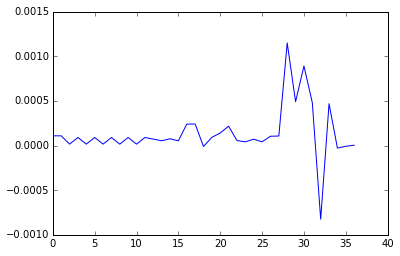

In [27]:
plot n2coeffs

-> plot(n1coeffs)


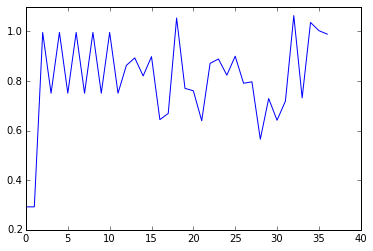

In [28]:
plot n1coeffs

-> plot(n0coeffs)


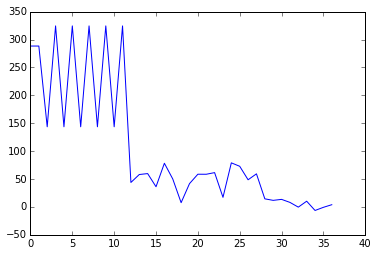

In [29]:
plot n0coeffs

In [108]:
df = pd.DataFrame.from_items(res).T

In [109]:
df = df.reset_index()

In [110]:
df.head()

,index,0,1,2
0,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T16...,0.000109,0.292508,288.277513
1,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T17...,0.000109,0.292508,288.277513
2,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499
3,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,0.000090,0.750774,324.376253
4,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499


In [111]:
df.columns = ['filename', 'coeff_2','coeff_1','coeff_0'] 

In [112]:
df.head()

,filename,coeff_2,coeff_1,coeff_0
0,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T16...,0.000109,0.292508,288.277513
1,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T17...,0.000109,0.292508,288.277513
2,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499
3,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,0.000090,0.750774,324.376253
4,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499


In [113]:
def get_time(fname):
    return io.Filename(fname).time

In [114]:
df['time'] = df.filename.map(get_time)

In [115]:
df.set_index('time', inplace=True)

In [116]:
df.iloc[:10]

,filename,coeff_2,coeff_1,coeff_0
time,,,,
2014-04-02 16:54:19,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T16...,0.000109,0.292508,288.277513
2014-04-02 17:12:32,mvn_iuv_l1b_cruisecal1-mode011-muv_20140402T17...,0.000109,0.292508,288.277513
2014-04-02 17:31:18,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499
2014-04-02 17:31:18,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,0.000090,0.750774,324.376253
2014-04-02 17:49:29,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T17...,0.000015,0.995765,143.575499
2014-04-02 17:49:29,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T17...,0.000090,0.750774,324.376253
2014-04-02 18:07:40,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T18...,0.000015,0.995765,143.575499
2014-04-02 18:07:40,mvn_iuv_l1b_cruisecal1-mode012-muv_20140402T18...,0.000090,0.750774,324.376253
2014-04-02 18:25:51,mvn_iuv_l1b_cruisecal1-mode012-fuv_20140402T18...,0.000015,0.995765,143.575499


In [120]:
same_p_fnames = df.filename.iloc[:2].values

In [121]:
import os

In [122]:
os.path.isabs(same_p_fnames[0])

False

In [ ]:
f1 = io.L1BReader(same_p_fnames[0]

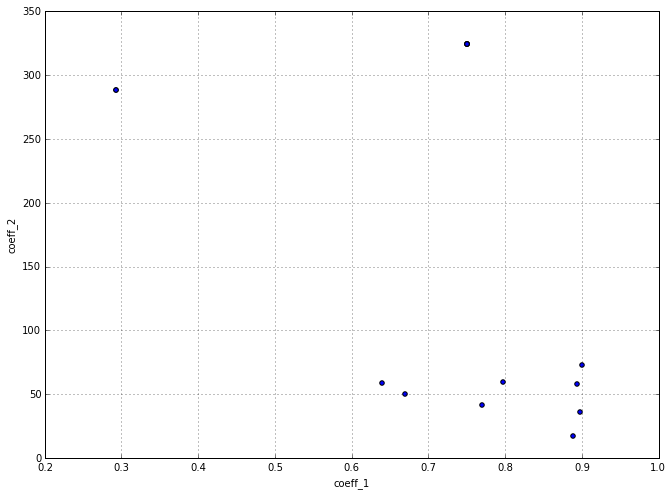

In [106]:
t = '20140402 19'
muv[t1].plot('coeff_1', 'coeff_2', kind='scatter')

In [87]:
muv = df[df.filename.str.contains('-muv_')]
fuv = df[df.filename.str.contains('-fuv_')]

In [93]:
rcParams['figure.figsize'] = (11,8)

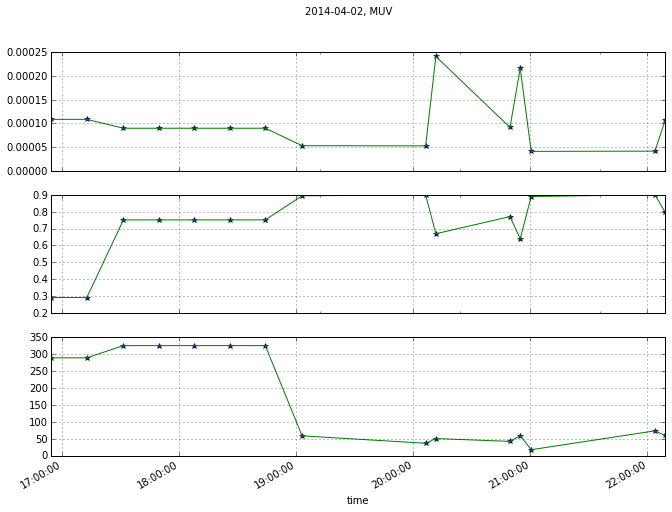

In [104]:
t1 = '20140402'
fig, axes = subplots(nrows=3)
fig.suptitle('2014-04-02, MUV')
for ax,i in zip(axes, range(3)):
    muv[t1]['coeff_'+str(i)].plot(ax=ax,style='*')
    muv[t1]['coeff_'+str(i)].plot(ax=ax)
savefig('t1_muv.png', dpi=150)

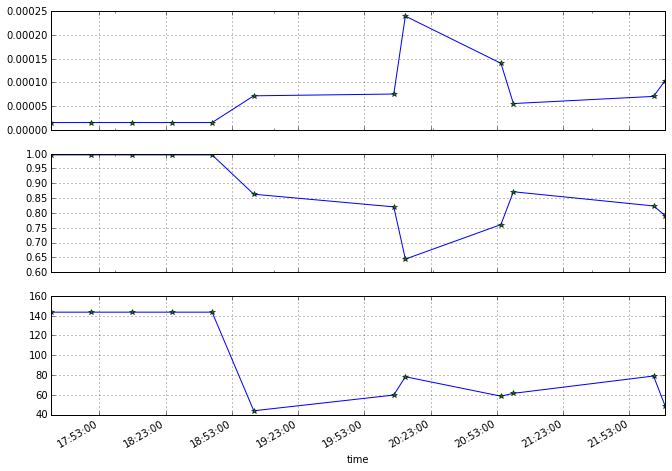

In [101]:
t1 = '20140402'
fig, axes = subplots(nrows=3)
for ax,i in zip(axes, range(3)):
    fuv[t1]['coeff_'+str(i)].plot(ax=ax)
    fuv[t1]['coeff_'+str(i)].plot(ax=ax,style='*')

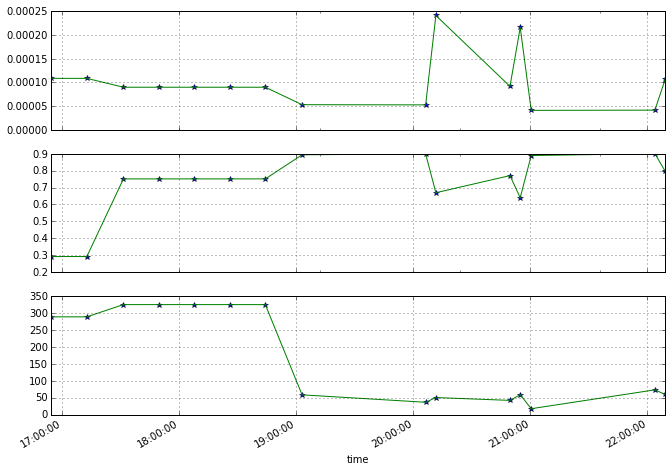

In [102]:
t2 = '20140521'
fig, axes = subplots(nrows=3)
fig
for ax,i in zip(axes, range(3)):
    muv[t1]['coeff_'+str(i)].plot(ax=ax, style='*')
    muv[t1]['coeff_'+str(i)].plot(ax=ax,)

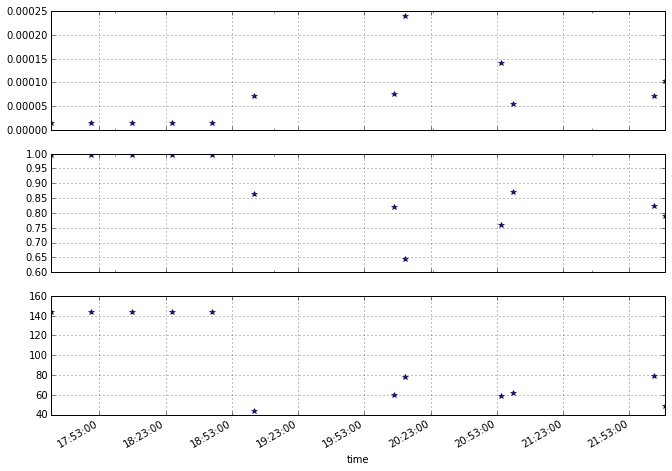

In [97]:
t2 = '20140521'
fig, axes = subplots(nrows=3)
for ax,i in zip(axes, range(3)):
    fuv[t1]['coeff_'+str(i)].plot(ax=ax, style='*')